# US Federal Public Debt Holders
This notebook examines the changing ownership structure of U.S. Federal Public Debt over time. I make use of quarterly data series sourced from [the Federal Reserve Economic Data (FRED) database](https://fred.stlouisfed.org).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT_TOTAL = 'Total Federal Debt'
FEDERAL_DEBT_HELD_BY_PUBLIC = 'Federal Debt Held by the Public'
FEDERAL_DEBT_HELD_BY_US_GOVERNMENT = 'Debt Held by US Government'
PFX = 'Debt Held by '
FEDERAL_DEBT_HELD_BY_FED = PFX + 'FED'
FEDERAL_DEBT_HELD_BY_FOREIGN = PFX + 'Foreign and International Investors'
FEDERAL_DEBT_HELD_BY_DOMESTIC = PFX + 'Domestic Owners'

### Federal Debt Holders, preparation of data
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FDHBATN` &mdash; The US intragovernmental part of the debt in millions (quarterly frequency).
* `FDHBFRBN` &mdash; Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency).
* `FDHBFIN` &mdash; Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)

The following relationships hold:
* `GFDEBTN` = `FYGFDPUN` + `FDHBATN`
* US Domestic ownership = `FYGFDPUN` - `FDHBFRBN` - `FDHBFIN`

In [4]:
# GFDEBTN   -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# FYGFDPUN  -- Federal Debt Held by the Public in millions (quarterly frequency)
# FDHBATN   -- Federal Debt Held by Agencies and Trusts in millions (quarterly frequency)
# GFDEBTN = FYGFDPUN + FDHBATN

# FDHBFRBN  -- Federal Debt Held by Federal Reserve Banks in billions (quarterly frequency)
# FDHBFIN   -- Federal Debt Held by Foreign and International Investors in billions (quarterly frequency)
# FYGFDPUN = FDHBFRBN + FDHBFIN + Domestic holdings

pub_debt_holders = web.get_data_fred(['GFDEBTN', 'FYGFDPUN', 'FDHBATN', 'FDHBFRBN', 'FDHBFIN'],
                                     start=report_start, end=report_end)

# Convert all amounts into millions
pub_debt_holders[['FDHBFRBN', 'FDHBFIN']] *= 1000

# Adding a new column for the domestic part
pub_debt_holders[FEDERAL_DEBT_HELD_BY_DOMESTIC] = pub_debt_holders.FYGFDPUN\
        - pub_debt_holders.FDHBFRBN - pub_debt_holders.FDHBFIN
    
# Truncating to the earliest quarter where all dataseries have data
pub_debt_holders.dropna(inplace=True)

### Visualization of prepared data

In [5]:
pub_debt_holders.rename(
    columns={'GFDEBTN': FEDERAL_DEBT_TOTAL,
             'FYGFDPUN': FEDERAL_DEBT_HELD_BY_PUBLIC, 'FDHBATN': FEDERAL_DEBT_HELD_BY_US_GOVERNMENT,
             'FDHBFRBN': FEDERAL_DEBT_HELD_BY_FED, 'FDHBFIN': FEDERAL_DEBT_HELD_BY_FOREIGN},
    inplace=True)
IDX_FORMAT = '{:%Y-%m}'

In [6]:
# The last 4 years
pub_debt_holders.tail(16).style.format_index(IDX_FORMAT).format('{:,.0f}M').set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]},
     {'selector':'.col0', 'props': [('min-width', '110px')]}])

,Total Federal Debt,Federal Debt Held by the Public,Debt Held by US Government,Debt Held by FED,Debt Held by Foreign and International Investors,Debt Held by Domestic Owners
DATE,,,,,,
2021-01,"28,132,570M","22,006,863M","6,125,707M","5,401,362M","7,038,300M","9,567,201M"
2021-04,"28,529,436M","22,353,532M","6,175,904M","5,644,351M","7,518,900M","9,190,281M"
2021-07,"28,428,919M","22,305,879M","6,123,040M","5,911,599M","7,570,900M","8,823,380M"
2021-10,"29,617,215M","23,168,329M","6,448,886M","6,141,499M","7,740,400M","9,286,430M"
2022-01,"30,400,960M","23,903,280M","6,497,680M","6,254,966M","7,604,200M","10,044,114M"
2022-04,"30,568,582M","23,933,481M","6,635,101M","6,216,801M","7,416,900M","10,299,780M"
2022-07,"30,928,912M","24,320,206M","6,608,706M","6,097,085M","7,251,500M","10,971,621M"
2022-10,"31,419,689M","24,539,241M","6,880,448M","5,944,675M","7,197,800M","11,396,766M"
2023-01,"31,458,438M","24,714,826M","6,743,612M","5,713,249M","7,471,400M","11,530,177M"


In [7]:
FED_DEBT_HOLDERS_TITLE = 'US Federal Public Debt Holders and Their Amounts'
FED_DEBT_HOLDERS_PERCENTAGE_TITLE = 'US Federal Public Debt Holders and Their Ownership'
LEFT_Y_AXIS_LABEL = 'Billions of USD'

#### Displaying each holding independently

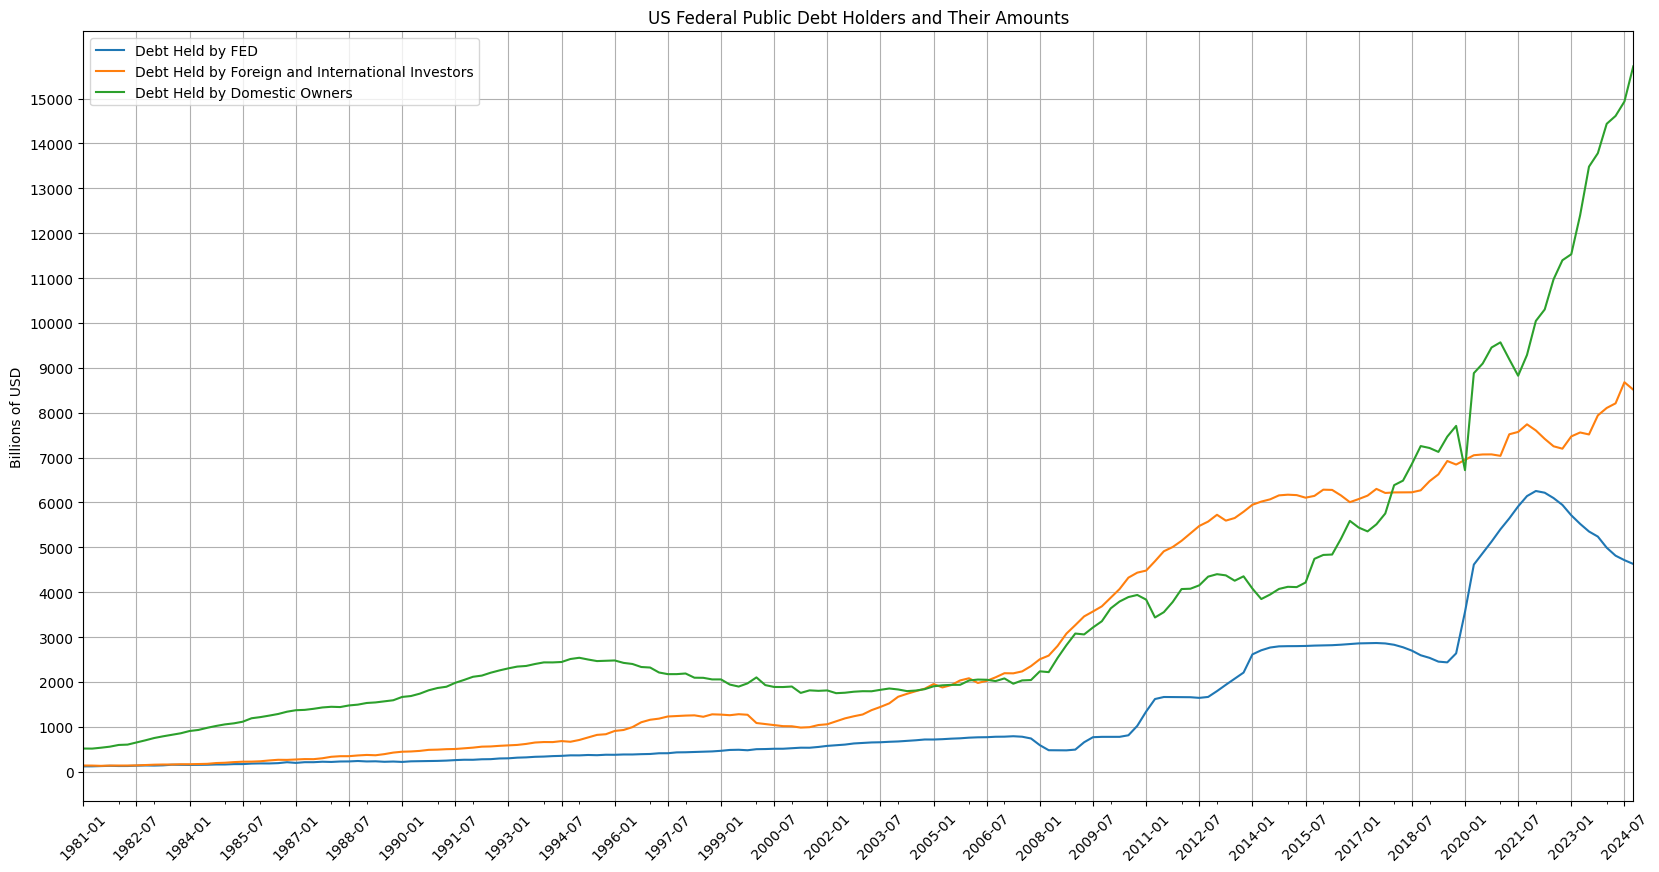

In [8]:
smaller_df = pub_debt_holders[[FEDERAL_DEBT_HELD_BY_FED, FEDERAL_DEBT_HELD_BY_FOREIGN, FEDERAL_DEBT_HELD_BY_DOMESTIC]]
ax = smaller_df.plot(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                     xticks=pub_debt_holders.index[::6], xlabel='', rot=45,
                     ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 16000e3, 1000e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders.index[::6])))

#### Stacked Visualization Amounting to Total US Federal Debt

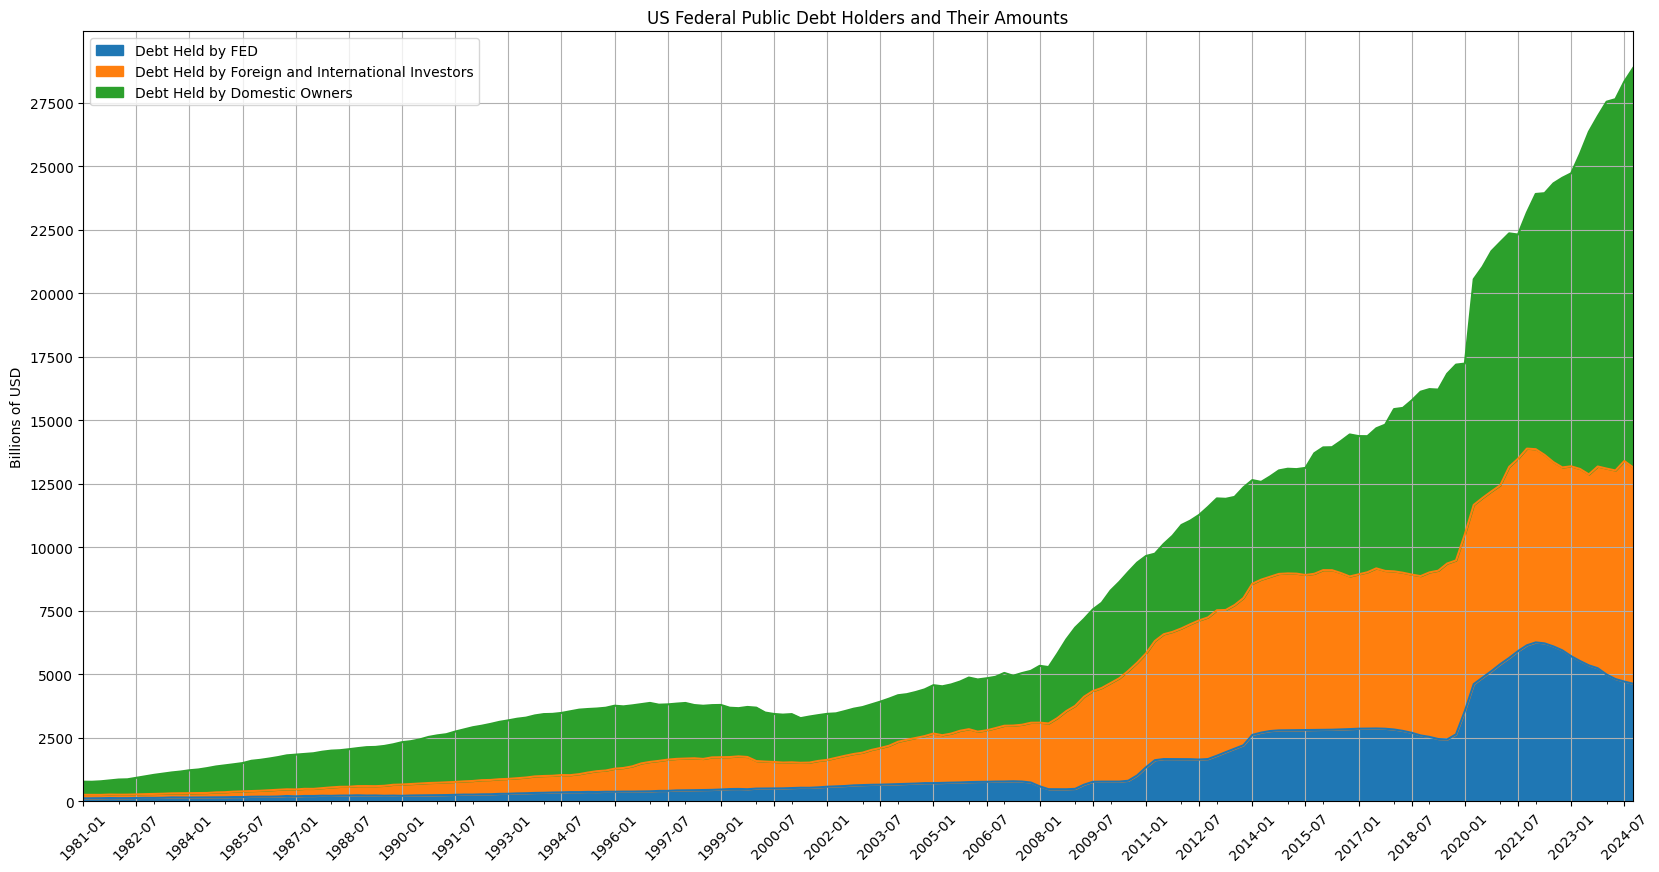

In [9]:
ax = smaller_df.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_TITLE,
                          xticks=pub_debt_holders.index[::6], xlabel='', rot=45,
                          ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 30000e3, 2500e3))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: "%.0f" % (x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders.index[::6])))

#### Visualization of Ownership as a Percentage of Total Federal Debt

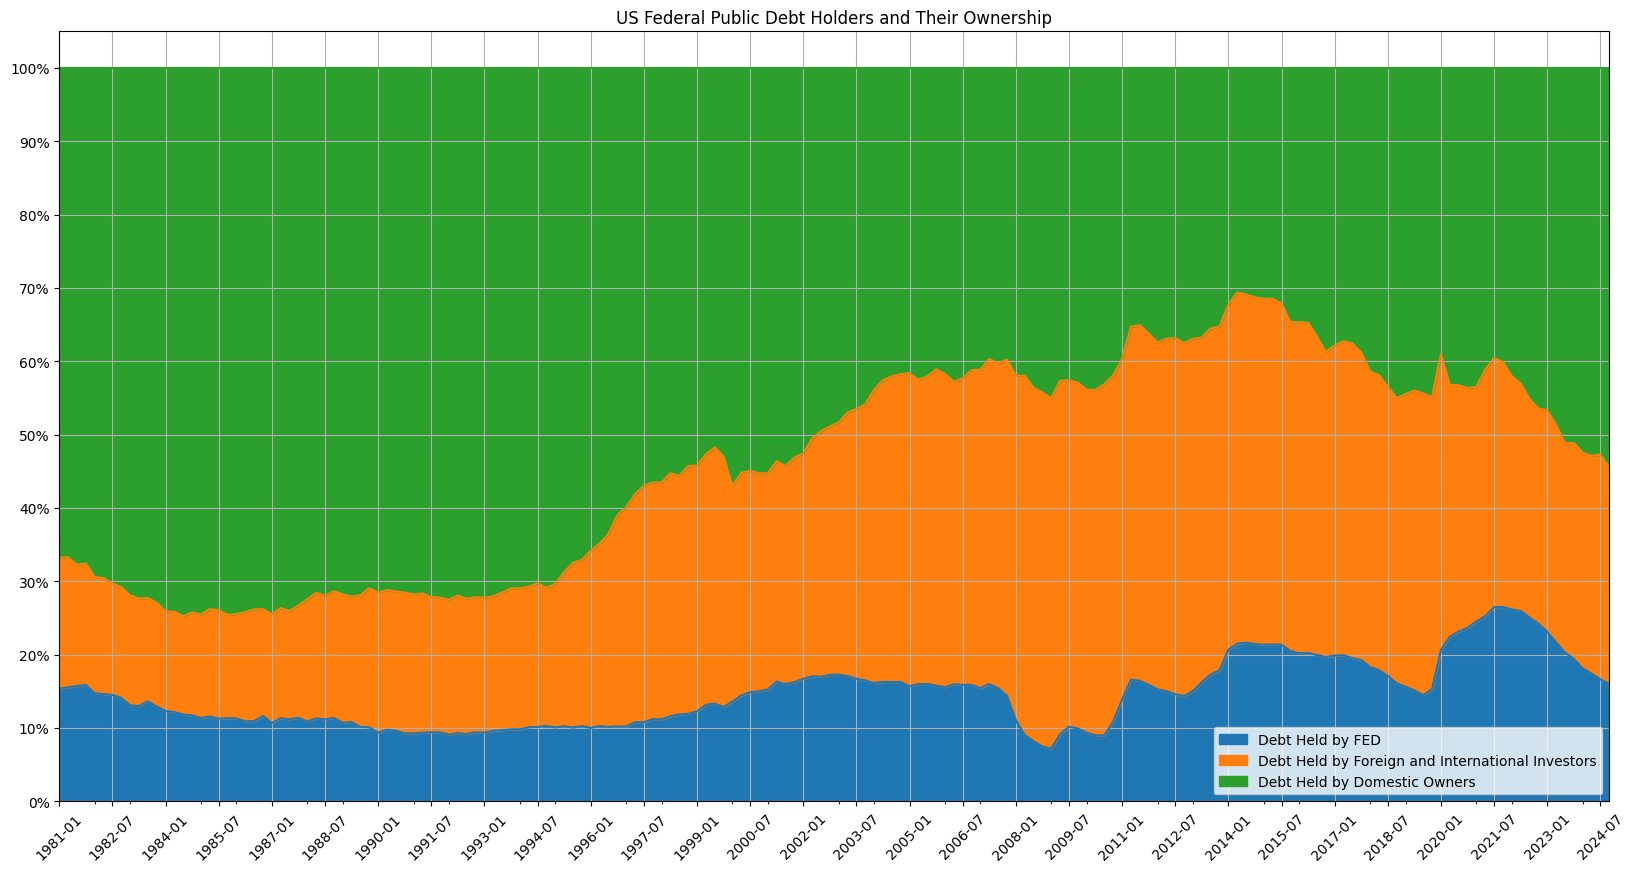

In [10]:
# Converting to percentages by dividing by total federal public debt.
# Dividing by a sum of FYGFDPUN and FDHBATN instead of by GFDEBTN because of a small issue in the Fred's dataset
smaller_df_pct = smaller_df.divide(pub_debt_holders.iloc[:, 1], axis=0)

ax = smaller_df_pct.plot.area(figsize=(20,10), grid=True, title=FED_DEBT_HOLDERS_PERCENTAGE_TITLE,
                              xticks=pub_debt_holders.index[::6], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pub_debt_holders.index[::6])))

Let's look at ownership over the past 16 quarters.

In [11]:
PCNT_FORMAT = '{:.4%}'.format

# The last 4 years
smaller_df_pct.tail(16).style.format_index(IDX_FORMAT).format(PCNT_FORMAT).set_table_styles(
    [{'selector':'.index_name.level0', 'props': [('min-width', '78px')]}])

,Debt Held by FED,Debt Held by Foreign and International Investors,Debt Held by Domestic Owners
DATE,,,
2021-01,24.5440%,31.9823%,43.4737%
2021-04,25.2504%,33.6363%,41.1133%
2021-07,26.5024%,33.9413%,39.5563%
2021-10,26.5082%,33.4094%,40.0824%
2022-01,26.1678%,31.8124%,42.0198%
2022-04,25.9753%,30.9896%,43.0350%
2022-07,25.0700%,29.8168%,45.1132%
2022-10,24.2252%,29.3318%,46.4430%
2023-01,23.1167%,30.2304%,46.6529%


Percentage changes in the last quarter

In [12]:
df_change_last_quarter_1 = (smaller_df_pct.iloc[-1] - smaller_df_pct.iloc[-2])\
    .apply(PCNT_FORMAT).to_frame('Percentage change in ownership')

In [14]:
df_change_last_quarter_2 = (smaller_df.iloc[-1]-smaller_df.iloc[-2]).\
    apply('${:+,.0f}mn'.format).to_frame('Changes over quarter starting on {:%Y-%m-%d}'.format(pub_debt_holders.index[-1]))

In [15]:
pd.concat([df_change_last_quarter_2, df_change_last_quarter_1], axis=1)

,Changes over quarter starting on 2024-10-01,Percentage change in ownership
Debt Held by FED,"$-84,706mn",-0.6011%
Debt Held by Foreign and International Investors,"$-165,600mn",-1.1401%
Debt Held by Domestic Owners,"$+783,716mn",1.7412%


In [16]:
print('US Federal Public Debt changed by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((pub_debt_holders.iloc[-1,1]-pub_debt_holders.iloc[-2,1])/1000., pub_debt_holders.index[-1].date()))

US Federal Public Debt changed by +533.41bn in quarter starting on 2024-10-01


### Changes in Federal Public Debt Ownership Over the Past Years
Let's see by how many percentage points each category of US Public Debt holders changed their ownership over the past 5 and 3 years.

In [17]:
periods = [3, 1]

In [18]:
df_pct_chg = pd.concat(
    [(smaller_df_pct - smaller_df_pct.shift(4*period)).iloc[-1] for period in periods], axis=1)
# Converting to billions of USD
df_chg = pd.concat([(smaller_df - smaller_df.shift(4*period)).iloc[-1] for period in periods], axis=1) / 1e3
df_pct_chg.columns = df_chg.columns = ['Over past {:d} years'.format(period) for period in periods]
df_pct_chg.index = df_chg.index = df_chg.index.map(lambda lbl: lbl[len(PFX):])

In [19]:
df_pct_chg.sort_values(by=df_pct_chg.columns[0], inplace=True)

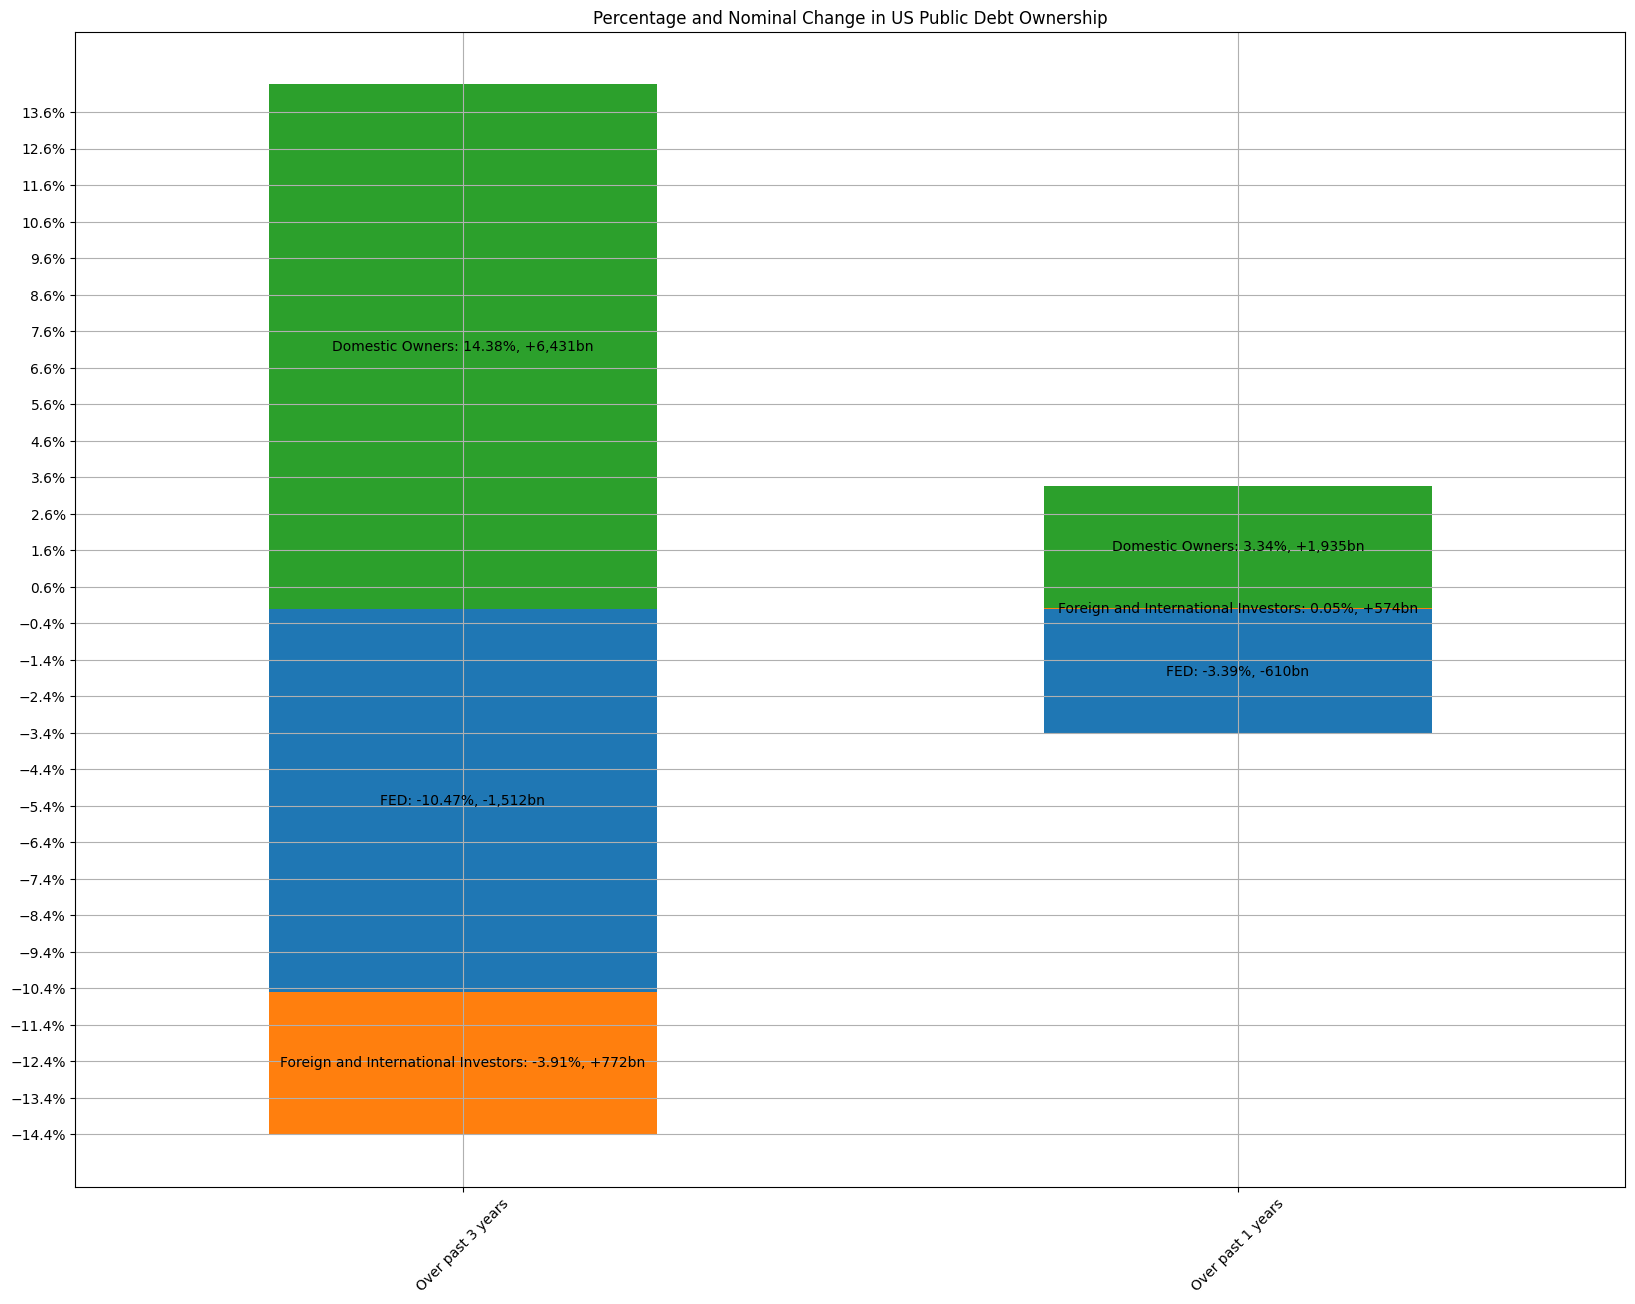

In [20]:
y_min = df_pct_chg.loc[df_pct_chg.iloc[:,0] < 0., df_pct_chg.columns[0]].sum().item()
y_max = df_pct_chg.loc[df_pct_chg.iloc[:,0] > 0., df_pct_chg.columns[0]].sum().item()
ax = df_pct_chg.T.plot.bar(figsize=(20,15), grid=True, title='Percentage and Nominal Change in US Public Debt Ownership',
                           stacked=True, rot=45, yticks=np.arange(y_min, y_max, .01))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label() + f': {a:.2%}, {df_chg.loc[c.get_label()].iloc[i]:+,.0f}bn'
          if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type='center')
    #ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')